In [2]:
from src.utils import *

# Load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely.errors import TopologicalError
from unidecode import unidecode
import glob
import csv
from datetime import datetime
import dask.dataframe as dd
import dask_geopandas as dg
from dask.distributed import Client
import gc
import re


# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
outdata_f = os.path.join(indata_f, 'OutputData', 'step1_GQA')
if not os.path.exists(outdata_f):
    # Create the folder if it doesn't exist
    os.makedirs(outdata_f)

# 0 PREPARE A LOG FILE FOR QC
log_file = 'log_GQA_Step1.csv'
log_path = os.path.join(outdata_f, log_file)

# Initialize Dask client
client = Client()

# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}


# 1 READ URBAN CENTRES
# Read shapefile
uc_file_path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_InputUpdateB2B3B4Copy.shp')
# Read the GeoPackage file
uc = gpd.read_file(uc_file_path)
uc['CNTR_CODE'].fillna('AA', inplace=True)

# Select cities for processing in this batch
###uc_sel = uc.query('Batch==1.0 & CNTR_CODE != "SE"')
uc_sel = uc.query('Batch==4 and CNTR_CODE=="FR"')
uc_sel = uc_sel.sort_values(by='CNTR_CODE')

# Read table to list the cities to process using urban centre code
cities_ls = uc_sel.HDENS_CLST.tolist()
len(cities_ls)

# Final GQAs
QGA_Final_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\GQA'

# 1 UA DATA FOLDER
ua_data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'

# 2 READ NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')

# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

# 3 TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

# Read table with HDENS Urban centres information and Agglomerations link
HDENS_AGGL_tbl = pd.read_csv(r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\UrbanCentres_Agglomerations_csv.csv')
# Join uc code field to this table
HDENS_AGGL_tbl = HDENS_AGGL_tbl.merge(uc[['POPL_2021', 'HDENS_CLST']], on='POPL_2021')

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
c:\Users\ubach\Projects\GQA\src\utils.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

1
2024-10-24 11:13:26.744192
FR-GEOSTAT21_316-AG_FR_00_14-Dunkerque
Loading agglomeration boundary for selected city
ncm


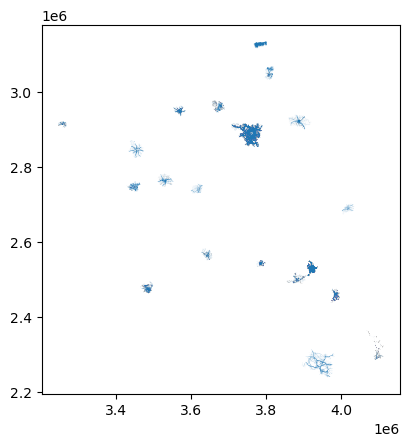

In [2]:
counter= 1
agl_error_ls = []

# Loop through test cities
for uc_city_code in cities_ls[:1]:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))

    ua_path = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()
    if ua_path == 'not available':
        agl_error_ls.append(uc_city_code +" UA not available")
    
    else:
        inGQA = os.path.join(QGA_Final_path, '{}_finalGQA.shp'.format(uc_city_code))
        if not os.path.exists(inGQA):
            urban_center = uc.query(f'HDENS_CLST=="{uc_city_code}"')
            HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
            agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
            for agl_id in agl_id_city_ls:
                HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
                ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
                aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
                aglo_name = aglo_name.split('/')[0]
                aglo_name = aglo_name.split(' ')[0]

                if len(ctry_code.split('-'))>1:
                    print(F'>1 countries {ctry_code}')
                    ctry_code = ctry_code.split('-')[0]
                
                city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
                
                if ctry_code=='FR':
                    print(city_agl_cd)    
                    # Load agglomeration boundary for selected city
                    agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
                    if agl_city.empty:
                        agglomerationId_identifier = 'NotAvailable'
                        print ("agglomerationId_identifier Not Available")
                        agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
                    else:
                        output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                        if not os.path.exists(output_path):
                            
                            # Check noise contour maps GeoPackage file
                            ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_FR_update.gpkg')
                            layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                            #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                            #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                            #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                            ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                                engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                            print ("ncm")

                            
                            ax = ncm.plot()
                            agl_city.plot(ax=ax)
                            plt.show()

In [ ]:
ax = ncm.plot()
agl_city.plot(ax=ax)
plt.show()

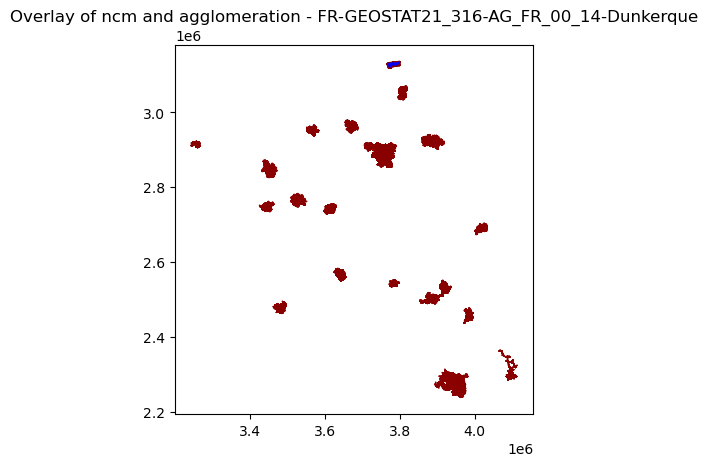

In [8]:
# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the second GeoDataFrame
ncm.plot(ax=ax, edgecolor='darkred')

# Plot the first GeoDataFrame
agl_city.plot(ax=ax, color='blue')

# Add title and labels
ax.set_title(f'Overlay of ncm and agglomeration - {city_agl_cd}')
plt.show()

In [4]:
tuple(agl_city.total_bounds)

(3766957.5079924, 3118274.908384005, 3801025.2966107, 3135248.9725492005)

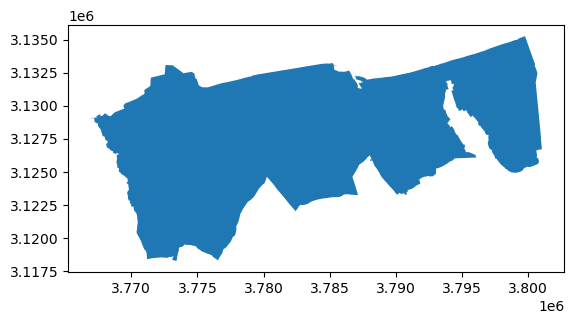

In [7]:
agl_city.plot()
plt.show()

In [ ]:
ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                    engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
print ("ncm")

In [9]:
ncm_fiona = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], engine='fiona', bbox=tuple(agl_city.total_bounds))

2024-10-24 11:31:30,551 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-10-24 11:31:36,125 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


2024-10-24 11:33:00,600 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-10-24 11:33:08,256 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


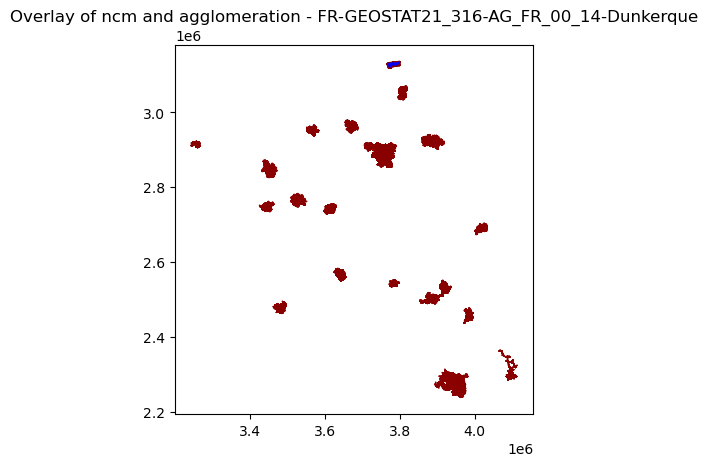

In [10]:
# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the second GeoDataFrame
ncm_fiona.plot(ax=ax, edgecolor='darkred')

# Plot the first GeoDataFrame
agl_city.plot(ax=ax, color='blue')

# Add title and labels
ax.set_title(f'Overlay of ncm and agglomeration - {city_agl_cd}')
plt.show()

In [11]:
import geopandas as gpd

# Load the data using pyogrio (without bbox filtering)
ncm_pio_arrow = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], engine='pyogrio', use_arrow=True)

# Manually apply the bounding box filter
bbox = tuple(agl_city.total_bounds)
ncm_filtered = ncm_pio_arrow.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]  # xmin, ymin, xmax, ymax


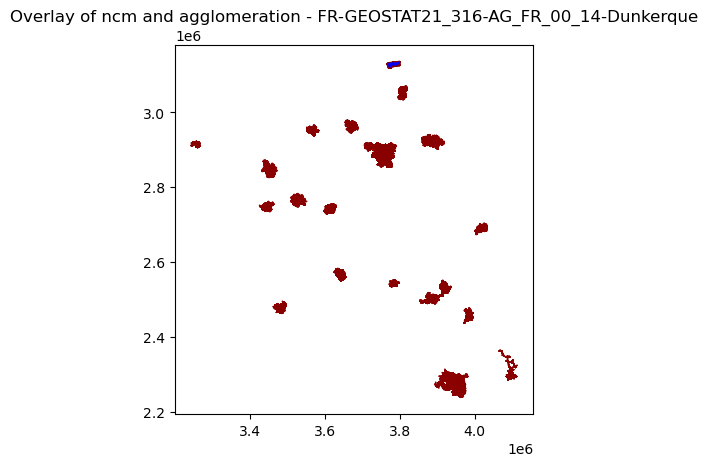

In [12]:
# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the second GeoDataFrame
ncm_filtered.plot(ax=ax, edgecolor='darkred')

# Plot the first GeoDataFrame
agl_city.plot(ax=ax, color='blue')

# Add title and labels
ax.set_title(f'Overlay of ncm and agglomeration - {city_agl_cd}')
plt.show()

In [13]:
ncm_clipped = gpd.clip(ncm, agl_city)

<AxesSubplot: >

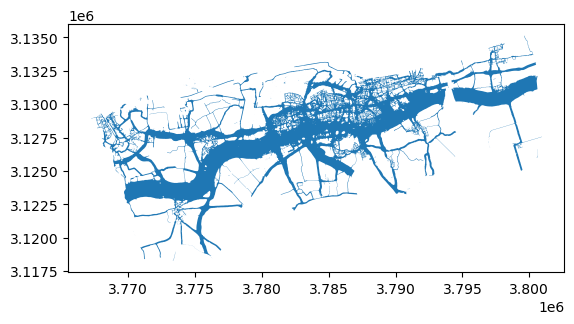

In [14]:
ncm_clipped.plot()

In [3]:
len(cities_ls)

6

In [4]:
counter= 1
agl_error_ls = []

# Loop through test cities
for uc_city_code in cities_ls:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))

    ua_path = codes.query(f'HDENS_CLST=="{uc_city_code}"').UA2018.values[0].strip()
    if ua_path == 'not available':
        agl_error_ls.append(uc_city_code +" UA not available")
    
    else:
        inGQA = os.path.join(QGA_Final_path, '{}_finalGQA.shp'.format(uc_city_code))
        if not os.path.exists(inGQA):
            urban_center = uc.query(f'HDENS_CLST=="{uc_city_code}"')
            HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
            agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
            for agl_id in agl_id_city_ls:
                HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
                ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
                aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
                aglo_name = aglo_name.split('/')[0]
                aglo_name = aglo_name.split(' ')[0]

                if len(ctry_code.split('-'))>1:
                    print(F'>1 countries {ctry_code}')
                    ctry_code = ctry_code.split('-')[0]
                
                city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
                print(city_agl_cd)
                if ctry_code=='FR':
                    print('Loading agglomeration boundary for selected city')      
                    # Load agglomeration boundary for selected city
                    agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
                    if agl_city.empty:
                        agglomerationId_identifier = 'NotAvailable'
                        print ("agglomerationId_identifier Not Available")
                        agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
                    else:
                        output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                        if not os.path.exists(output_path):
                            try:
                                # Check noise contour maps GeoPackage file
                                ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_FR_update.gpkg')
                                layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                                #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                                #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                                #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                                ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                                    engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                                print ("ncm")

                                ncm = gpd.clip(ncm, agl_city)

                                # Define the list of noisy classes
                                noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
                                print(noisy_classes)
                                # Create a condition based on the category column
                                condition = ncm['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                                # Specify the condition and create a new category column based on the condition
                                ncm['noisy'] = 0
                                ncm.loc[condition, 'noisy'] = 1
                                ncm = ncm[['noisy', 'geometry']]
                                print(ncm)
                                ncm_dis_dg = dg.from_geopandas(ncm, npartitions=10)
                                ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                                print ("ncm_dis")

                                # Perform spatial overlay (intersection) 
                                ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')
                                print ("ncm_agl")

                                # Aggregate the area with lower band values (quieter bands)
                                ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                                print ("union")

                                ncm_agl_city['noisy'] = ncm_agl_city.noisy.fillna(0)
                                print ("fillna")

                                # Select a subset of columns of interest
                                ncm_dis = ncm_agl_city[['noisy', 'geometry']]
                                print(ncm_dis)
                                

                                # 3 READ URBAN ATLAS DATA       
                                file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
                                # Read the GeoPackage file
                                ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                                            columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], 
                                            engine='pyogrio', 
                                            use_arrow=True, bbox= tuple(urban_center.total_bounds))
                                print ("loaded ua in urban city")                        

                                # Select 'green' classes
                                uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                                
                                # 4 SELECT UA INTERSECTING UC
                                # Perform spatial overlay (intersection)
                                uagreen_urbc = gpd.overlay(uagreen, urban_center, how='intersection')

                                # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                                # Perform spatial overlay (intersection)
                                nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                                not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                                # Filter out empty polygons(not empty polygons)
                                green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                                # save to shapefile
                                file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                                #green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                                print ("green_not_covered_by_ncm")

                                # 6 IDENTIFY QUIET/NOISY AREAS
                                ## for statistics need to calculate area again
                                # Calculate the area for each geometry and create a new column 'area'
                                nqgreen['area_m2'] = nqgreen['geometry'].area
                                nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                                nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                                nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                                nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                                nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                                # 7 EXPORT GREEN QUIET AREAS (GQA)
                                nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                                GQA = nqgreen.query('noisy == 0')
                                GNA = nqgreen.query('noisy == 1')

                                # Export to shapefile
                                print ('Export to shapefile')
                                GQA_uc_aglo_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                                print (GQA_uc_aglo_path)
                                GQA.to_file(GQA_uc_aglo_path, driver='ESRI Shapefile')
                                print ("GQA")

                                # 8 CREATE CENTROIDS FOR GQA POLYGONS
                                # Create a new GeoDataFrame with centroids as points
                                GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                                GQA_pts['oid'] = GQA.index
                                GQA_pts['fua_name'] = GQA.fua_name
                                GQA_pts['fua_code'] = GQA.fua_code
                                GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                                # Export to shapefile
                                file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                                GQA_pts.to_file(file_path, driver='ESRI Shapefile')

                                print ("GQA_pts")
                        
                                # Calculate the duration
                                end_time = datetime.now()
                                processing_time = end_time - start_time

                                print ("str(processing_time)")
                                
                                ## write output values into log file
                                uc_km2 = round(uc_city.area.sum()/1000000,2)
                                agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                                ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                                ua_km2 = round(ua.area.sum()/1000000,2)
                                uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                                uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                                nqgreen_m2 = round(nqgreen.area.sum(),2)
                                green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                                GQA_m2 = round(GQA.area.sum(),2)
                                GNA_m2 = round(GNA.area.sum(),2)
                                processing_duration = str(processing_time)

                                log_entry = create_log_entry(aglo_name, agl_id, uc_km2, agl_city_km2, 
                                                        ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                        green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                                write_log(log_path, log_entry)

                                # Clean up intermediate variables to free memory
                                del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                            except:
                                print("Error " + city_agl_cd)
                                agl_error_ls.append(city_agl_cd +" Topological error")
    counter= counter+1

print(agl_error_ls)

1
2024-10-24 14:03:08.645758
FR-GEOSTAT21_496-AG_FR_00_27-Nantes
Loading agglomeration boundary for selected city
2
2024-10-24 14:03:08.696829
FR-GEOSTAT21_499-AG_FR_00_43-Tours
Loading agglomeration boundary for selected city
3
2024-10-24 14:03:08.719776
FR-GEOSTAT21_906-AG_FR_00_3-Aubergenville
Loading agglomeration boundary for selected city
FR-GEOSTAT21_906-AG_FR_00_4-Beauchamp
Loading agglomeration boundary for selected city
FR-GEOSTAT21_906-AG_FR_00_7-Brunoy
Loading agglomeration boundary for selected city
FR-GEOSTAT21_906-AG_FR_00_10-Cergy
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3734761.298 2910761.686, 37347...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3748444.000 2910826.436, 37484...
1    0.0  MULTIPOLYGON (((3749005.517 2911300.100, 3749

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_10-Cergy_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_10-Cergy
FR-GEOSTAT21_906-AG_FR_00_12-Courcouronnes
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3772934.715 2867542.998, 37729...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3780101.509 2860785.617, 37801...
1    0.0  MULTIPOLYGON (((3780276.491 2860723.647, 37802...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_12-Courcouronnes_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_12-Courcouronnes
FR-GEOSTAT21_906-AG_FR_00_19-Le
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3738367.634 2892674.329, 37383...
ncm_dis


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_87476\1618761953.py:73: UserWarning: `keep_geom_type=True` in overlay resulted in 3658 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')


ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3735384.554 2896317.022, 37353...
1    0.0  MULTIPOLYGON (((3752748.671 2898299.236, 37527...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_19-Le_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_19-Le
FR-GEOSTAT21_906-AG_FR_00_24-Montmorency
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3755923.533 2910091.679, 37559...
ncm_dis


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_87476\1618761953.py:73: UserWarning: `keep_geom_type=True` in overlay resulted in 2561 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')


ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3755292.449 2906795.146, 37552...
1    0.0  MULTIPOLYGON (((3762101.647 2910995.404, 37621...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_24-Montmorency_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_24-Montmorency
FR-GEOSTAT21_906-AG_FR_00_30-Orsay
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3749943.916 2863459.725, 37499...
ncm_dis


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_87476\1618761953.py:73: UserWarning: `keep_geom_type=True` in overlay resulted in 6889 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')


ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3740643.048 2873939.685, 37406...
1    0.0  MULTIPOLYGON (((3759563.756 2876424.434, 37595...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_30-Orsay_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_30-Orsay
FR-GEOSTAT21_906-AG_FR_00_31-Paris
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3778895.772 2876959.964, 37788...
ncm_dis


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_87476\1618761953.py:73: UserWarning: `keep_geom_type=True` in overlay resulted in 20180 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')


ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3746319.541 2891185.173, 37463...
1    0.0  MULTIPOLYGON (((3779959.504 2896546.252, 37799...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_31-Paris_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_31-Paris
FR-GEOSTAT21_906-AG_FR_00_35-Roissy-en-France
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3764802.069 2912205.089, 37648...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3763228.023 2902293.570, 37632...
1    0.0  MULTIPOLYGON (((3789630.639 2909375.077, 37896...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_35-Roissy-en-France_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_35-Roissy-en-France
FR-GEOSTAT21_906-AG_FR_00_37-Sainte-Geneviève-des-Bois
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3758621.271 2861169.215, 37586...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3741669.096 2859162.520, 37416...
1    0.0  MULTIPOLYGON (((3761272.714 2865370.896, 37612...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_37-Sainte-Geneviève-des-Bois_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_37-Sainte-Geneviève-des-Bois
FR-GEOSTAT21_906-AG_FR_00_40-Torcy
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3779915.490 2895476.131, 37799...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3776810.415 2889818.347, 37768...
1    0.0  MULTIPOLYGON (((3784811.614 2879609.153, 37848...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_40-Torcy_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_40-Torcy
FR-GEOSTAT21_906-AG_FR_00_45-Versailles
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3741488.074 2876366.749, 37414...
ncm_dis


Q:\UserTemp\ubach\AppData\Local\Temp\40\ipykernel_87476\1618761953.py:73: UserWarning: `keep_geom_type=True` in overlay resulted in 1922 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl = gpd.overlay(ncm_dis, agl_city, how='intersection')


ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3734561.428 2886355.615, 37345...
1    0.0  MULTIPOLYGON (((3751078.977 2880755.192, 37510...
loaded ua in urban city


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\pygeos\set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_906-AG_FR_00_45-Versailles_GQA.shp
GQA
GQA_pts
str(processing_time)
Error FR-GEOSTAT21_906-AG_FR_00_45-Versailles
4
2024-10-24 15:33:48.302209
FR-GEOSTAT21_432-AG_FR_00_3-Aubergenville
Loading agglomeration boundary for selected city
ncm
['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']
   noisy                                           geometry
0      1  MULTIPOLYGON (((3709885.037 2902456.043, 37099...
ncm_dis
ncm_agl
union
fillna
   noisy                                           geometry
0    1.0  MULTIPOLYGON (((3748189.690 2904642.070, 37481...
1    0.0  MULTIPOLYGON (((3743024.659 2905824.664, 37430...
loaded ua in urban city
green_not_covered_by_ncm
Export to shapefile
P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\step1_GQA\FR-GEOSTAT21_432-AG_FR_00_3-Auberg